In [1]:
import pandas as pd
%matplotlib inline
from pydub import AudioSegment
import matplotlib.pyplot as plt
import math
import numpy as np
from copy import deepcopy

import json
import os

import scipy.io.wavfile
from scipy.io.wavfile import read
from scipy import signal


artists = pd.read_csv('fma_metadata/raw_artists.csv')
tracks = pd.read_csv('fma_metadata/raw_tracks.csv')
genres = pd.read_csv('fma_metadata/raw_genres.csv')

# artists.head()
# tracks.rename(columns=tracks.iloc[1])
# print(tracks.columns.values)
# print(genres.head(10))
# print(tracks)


In [2]:
# import pickle
# f = open('top_genre.txt', 'rb')
# # f.close()
# top_genre = pickle.load(f)
# f.close()
# # top_genre
genre = pd.read_csv('genre.csv')
print(genre.columns.values)
print(genre[genre['track_id'] == 2])


['Unnamed: 0' 'track_id' 'genre_top']
   Unnamed: 0  track_id genre_top
0           0         2   Hip-Hop


In [3]:
# rootdir = 'fma_small'

# MAX_SONGS = 8000

# numSongs = 0

# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#         try:
# #         print(file)

#             if not file.endswith(".mp3"):
#                 continue
#             if (numSongs %100 == 0):
#                 print(numSongs)
#             numSongs += 1
#             if (numSongs > MAX_SONGS):
#                 break
                
#             track_id = int(os.path.splitext(file)[0])
            
#             sound = AudioSegment.from_mp3(os.path.join(subdir, file))
#             if sound.channels == 2:
#                 [left, right] = sound.split_to_mono()
#                 sound = right
#                 sound.set_channels(1)
                
# #             print(os.path.splitext(file))
# #             print(subdir.split("\\")[1])
#             newDir = "wav/" + subdir.split("\\")[1]
#             if not os.path.exists(newDir):
#                 os.makedirs(newDir)
#             sound.export(newDir +"/"+ os.path.splitext(file)[0] + ".wav", format="wav")

#         except Exception as e: 
#             print('Error with this file', e)
#     if (numSongs > MAX_SONGS):
#         break

In [4]:
from matplotlib.colors import Normalize
MAX_SONGS = 40

numSongs = 0


dim = 100 # length of the samples
offset = 2000 # start getting song values at this time

data_x = np.zeros((MAX_SONGS, 129, dim))
data_y = np.chararray((MAX_SONGS))

rootdir = 'wav'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        try:
#         print(file)

            if not file.endswith(".wav"):
                continue
            if (numSongs %100 == 0):
                print(numSongs)
            
                
            track_id = int(os.path.splitext(file)[0])
            
#             sound = AudioSegment.from_mp3(os.path.join(subdir, file))
#             if sound.channels == 2:
#                 [left, right] = sound.split_to_mono()
#                 sound = right
#                 sound.set_channels(1)
                
#             print(os.path.splitext(file))
#             print(subdir.split("\\")[1])
#             newDir = "wav/" + subdir.split("\\")[1]
#             if not os.path.exists(newDir):
#                 os.makedirs(newDir)
#             sound.export(newDir +"/"+ os.path.splitext(file)[0] + ".wav", format="wav")

            sr_value, x_value = scipy.io.wavfile.read(os.path.join(subdir,file))
    #         print('sr_value', sr_value)
    #         print('x_value', x_value.shape)
            f, t, Sxx = signal.spectrogram(x=x_value,fs=sr_value, axis=0)
    #         print('f ', f.shape)
    #         print('t, ', t.shape)
    #         print('Sxx', Sxx.shape)
    #         print(np.max(Sxx))
    #         print(np.mean(Sxx))
            Sxx = np.log(Sxx)

    #         fig = plt.figure(figsize=(20,5))
    #         plt.pcolormesh(t, f, Sxx)
    #         plt.savefig('spectrum')
#             plt.show()
    
            
            if Sxx.shape[1] < offset+dim:
                continue
                
            numSongs += 1
            if (numSongs > MAX_SONGS):
                break
                
#             data_x.append(Sxx[:,offset:offset+dim])
            data_x[numSongs-1, :, :] = Sxx[:,offset:offset+dim]
#             data_y.append(genre[genre['track_id'] == track_id]['genre_top'].iloc[0])
            data_y[numSongs-1] = genre[genre['track_id'] == track_id]['genre_top'].iloc[0]
        
        except Exception as e: 
            print('Error with this file', e)
    if (numSongs > MAX_SONGS):
        break
        
# in case numSongs < max_songs
print(data_x.shape)
# data_x = data_x.transpose()
data_x = data_x[0:numSongs-1, :, :]
data_y = data_y[0:numSongs-1]

np.save('data_x_spectrum', data_x)
np.save('data_y_spectrum', data_y)


0


C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


(40, 129, 100)


In [5]:
# data_x = np.load(open('data_x.txt', 'rb'))
# data_y = np.load(open('data_y.txt', 'rb'))

In [6]:
print('x data shape ', data_x.shape)
# print('y data ', data_y)
# print('unique genres ', np.unique(data_y))

def permuteRows(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p,:,:], b[p]

# # now I'll set the genres to be numbers from 0 to number of unique genres
# unique_genres = np.unique(data_y)
# genre_map = {}
# ind = 0
# for g in unique_genres:
# #     print(g)
#     genre_map[g] = ind
#     ind += 1
    
# data_y = np.vectorize(genre_map.__getitem__)(data_y)

# # Convert y data to one hot vector
# oneHot = np.zeros((len(data_y), len(unique_genres)))
# oneHot[np.arange(len(data_y)), data_y] = 1
# data_y = oneHot
# # print(data_y)

data_y_strings = data_y
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
data_y = encoder.fit_transform(data_y)

data_x, data_y = permuteRows(data_x, data_y)


x data shape  (40, 129, 100)


In [7]:
# gen1_ind = data_y[:,3] ==1
# print(data_x[gen1_ind, :][0:2])
# gen2_ind = data_y[:,2] ==1
# data_x[gen2_ind, :][0:2]

In [8]:
classes_amount = np.sum(data_y, axis=0)
print(classes_amount)

[ 3 20  5  3  2  7]


In [9]:
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten,\
    GlobalAveragePooling1D, GlobalMaxPooling1D, Lambda, Add
from keras.models import Sequential
from keras.regularizers import l2
from keras.regularizers import Regularizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

print('x shape ', data_x.shape)
print('y shape ', data_y.shape)

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.10, random_state=0)
# print(x_train.shape, x_test.shape)
# print(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.50, random_state=0)

input_dim = x_train.shape[1]
out_dim = y_train.shape[1]

C:\Program Files\Python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


x shape  (40, 129, 100)
y shape  (40, 6)


In [13]:
model = Sequential()
x_train_flat = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
x_train_flat = np.random.randn(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
print(x_train_flat.shape)
model.add(Dense(100,activation='relu',input_shape=(x_train_flat.shape[1],),kernel_regularizer=l2(0.01)))
# model.add(Conv1D(6, 3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
# model.add(MaxPooling1D(3))
# model.add(Conv1D(12, 3, activation='relu'))
# model.add(GlobalAveragePooling1D())
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(y_train.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

(18, 12900)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               1290100   
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 606       
Total params: 1,290,706
Trainable params: 1,290,706
Non-trainable params: 0
_________________________________________________________________


In [14]:
# model_output = model.fit(x_train,y_train,epochs=1,batch_size=20,verbose=1,validation_data=(x_val,y_val))
x_val_flat = x_train.reshape((x_val.shape[0], x_val.shape[1]*x_val.shape[2]))
model_output = model.fit(x_train_flat,y_train,epochs=1,batch_size=20,verbose=1,validation_data=(x_val_flat,y_val))

Train on 18 samples, validate on 18 samples
Epoch 1/1


InternalError: GPU sync failed

In [11]:
nb_filters_1=10
nb_filters_2=20
lenght_filters=4
pool_size_1=4
pool_size_2=2
dropout_prob_1=0.5
dropout_prob_2=0.5
# frames=2580
# frequency=128
frames = x_train.shape[1]
frequency = x_train.shape[2]
dense_size=100
nb_classes= y_train.shape[1]



input_placeholder = Input(shape=(frames, frequency))

conv_1 = Conv1D(nb_filters_1, lenght_filters,
                activation='relu', border_mode='same')(
            input_placeholder)
pool_1 = MaxPooling1D(pool_size_1)(conv_1)

conv_2 = Conv1D(nb_filters_1, lenght_filters,
                border_mode='same', activation='relu')(pool_1)
pool_2 = MaxPooling1D(pool_size_1)(conv_2)

conv_3 = Conv1D(nb_filters_2, lenght_filters,
                border_mode='same', activation='relu')(pool_2)
pool_3 = MaxPooling1D(pool_size_2)(conv_3)

global_mean = GlobalAveragePooling1D()(pool_3)
global_max = GlobalMaxPooling1D()(pool_3)

# concat = merge([global_mean, global_max], mode='concat',
#                concat_axis=-1)
concat = Add()([global_mean, global_max])

hidden = Dense(dense_size, activation='relu')(concat)
drop_1 = Dropout(dropout_prob_1)(hidden)
hidden_2 = Dense(dense_size, activation='relu')(drop_1)
drop_2 = Dropout(dropout_prob_1)(hidden_2)

output = Dense(nb_classes, activation='softmax')(drop_2)

model = Model(input=input_placeholder, output=output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# self.model = model

C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(10, 4, activation="relu", padding="same")`
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(10, 4, activation="relu", padding="same")`
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(20, 4, activation="relu", padding="same")`
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [ ]:
nb_epoch = 1
batch_size = 20
model.fit(x_train, y_train, batch_size=batch_size, epoch=nb_epoch,
                       validation_data=(x_val,y_val))

C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 9 samples, validate on 9 samples
Epoch 1/1


In [2]:
# Normal MLP

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.10, random_state=0)
# print(x_train.shape, x_test.shape)
# print(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.50, random_state=0)

input_dim = x_train.shape[1]
out_dim = y_train.shape[1]

#define a sequentail Model
model = Sequential()

#Hidden Layer-1
model.add(Dense(100,activation='relu',input_dim=input_dim,kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.3, noise_shape=None, seed=None))

#Hidden Layer-2
model.add(Dense(100,activation = 'relu',kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.3, noise_shape=None, seed=None))

#Output layer
model.add(Dense(out_dim,activation='sigmoid'))

C:\Program Files\Python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


NameError: name 'data_x' is not defined

In [23]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [1]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
#FIT MLP
model_output = model.fit(x_train,y_train,epochs=100,batch_size=20,verbose=1,validation_data=(x_val,y_val),)

Train on 1 samples, validate on 1 samples
Epoch 1/100


In [156]:
model.evaluate(x=x_test, y=y_test)

100/100 [==============================] - 0s 99us/step


[2.1803759574890136, 0.875]

In [175]:
import sklearn.metrics as metrics
y_pred = model.predict(x_test)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[0 0 1 0 0 3 0 0]
 [0 0 6 3 0 4 0 0]
 [0 0 5 5 0 6 0 0]
 [0 0 7 8 0 2 0 0]
 [0 0 2 1 0 1 0 0]
 [0 0 6 9 0 6 0 0]
 [0 0 4 3 0 4 0 0]
 [0 0 6 6 0 2 0 0]]


<function matplotlib.pyplot.show(*args, **kw)>

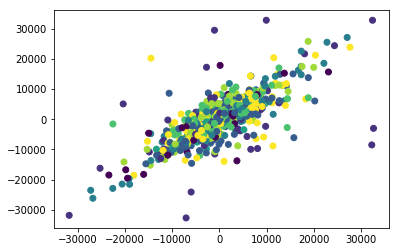

In [168]:
plt.scatter(data_x[:,0], data_x[:,1], c=np.argmax(data_y, axis=1))
plt.show

In [ ]:
# CNN

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.10, random_state=0)
# print(x_train.shape, x_test.shape)
# print(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.50, random_state=0)

input_dim = x_train.shape[1]
out_dim = y_train.shape[1]

x_train, y_train = x_train[np.newaxis],y_train[np.newaxis]
x_val, y_val = x_val[np.newaxis],y_val[np.newaxis]
x_test, y_test = x_test[np.newaxis],y_test[np.newaxis]


#define a sequentail Model
model = Sequential()

model.add(Conv1D(filters=40,
                 kernel_size=25,
                 input_shape=(x.shape[1:2],),
                 activation='relu',
                 kernel_regularizer=l2(5e-6),
                 strides=1))

#Hidden Layer-1
# model.add(Dense(100,activation='relu',input_dim=input_dim,kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.3, noise_shape=None, seed=None))

#Hidden Layer-2
model.add(Dense(100,activation = 'relu',kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.3, noise_shape=None, seed=None))

#Output layer
model.add(Dense(out_dim,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# FIT CNN
model_output = model.fit(x_train,y_train,epochs=1,batch_size=20,verbose=1,validation_data=(x_val,y_val),)

In [ ]:
model.evaluate(x=x_test, y=y_test)

(2643934,)
sound sample  [1635 3217 1519 3200 2149]
2
sound wav sample  [1635 3217 1519 3200 2149]
[-3145948.79812563+7232473.86236149j -2007257.38279631+7235025.50158188j
  9752418.35159211-8812223.27890449j -4263682.01292385-5106058.85823473j
  -885816.76131517+7886045.05582011j]


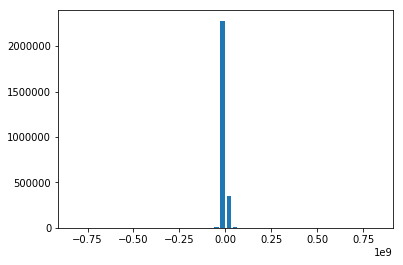

In [5]:
# %matplotlib inline
# from pydub import AudioSegment
# import matplotlib.pyplot as plt
# import math
# import numpy as np
# #import pydub

# #pydub.AudioSegment.converter = r"C:/Users/Peter/Downloads/Installers/ffmpeg-20190202-b429c86-win64-static/bin/ffmpeg.exe"
# sound = AudioSegment.from_mp3(r"fma_small/000/000002.mp3")
# # sound.set_channels(1)

# #[left, right] = sound.split_to_mono() not necessary since set them
# #sound = left
# numChannels = sound.channels
# frameRate = sound.frame_rate

# soundAr = np.array(sound.get_array_of_samples())
# #print(soundAr.shape[0]/numChannels, numChannels)
# print(soundAr.shape)
# print('sound sample ', soundAr[50000:50005])
# print(numChannels)

# sound = sound._spawn(data=soundAr)

# sound.export("file.wav", format="wav")
# sound = AudioSegment.from_wav(r"file.wav")
# soundAr = np.array(sound.get_array_of_samples())
# print('sound wav sample ', soundAr[50000:50005])


# #soundAr.reshape(math.floor(soundAr.shape[0]/numChannels), numChannels, order='F')

# '''
# normVal = np.linalg.norm(soundAr)
# print(soundAr[50000:50005])
# print(soundAr.shape)
# soundAr = soundAr / normVal
# print(soundAr[50000:50005])
# print(soundAr.shape)
# soundAr = np.floor(soundAr * normVal)
# soundAr = soundAr.astype(int)
# print(soundAr[50000:50005])
# print(soundAr.shape)
# '''
# x = np.fft.fft(soundAr)
# print(x[50000:50005])

# hist, bins = np.histogram(x, bins=50)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# plt.show()
# sound = sound._spawn(data=soundAr)

# sound.export("file.wav", format="wav")
# f = open('file.wav')
# f.close()

In [182]:


# Deal with the class imbalances by up sampling

classes_amount = np.sum(data_y, axis=0)
print(classes_amount)
max_num_single_class = np.max(np.sum(data_y, axis=0))
num_classes = len(np.sum(data_y, axis=0))
# print(np.argmax(data_y, axis=1))
data_x_before_balance = deepcopy(data_x)

for class_num in num_classes:
    n = classes_amount[class_num]
    gen_ind = data_y[:, class_num] == 1
    inst_of_class = data_x_before_balance[gen_ind, :]
    for i in range(max_num_single_class - n):
        # Add samples until the class is balanced
        #data_x.append(inst_of_class[np.randint(low=0, high=n, size=1),:])
        data_x = numpy.vstack([data_x, inst_of_class[np.randint(low=0, high=n, size=1),:]])


TypeError: cannot perform reduce with flexible type